In [1]:
import pandas as pd
import numpy as np
import os
from pandas.tseries.offsets import BDay
import pickle
import fnmatch
from scipy import stats
from dateutil.parser import parse
from pylab import *
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
import statsmodels as sts
import datetime as dt
import glob
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
#########
def listdirs(folder): #return only directories from a master folder
    return [d for d in os.listdir(folder) if os.path.isdir(os.path.join(folder, d))]

def find_path(basepath, stringname):
    for fname in os.listdir(basepath):
        path = os.path.join(basepath, fname)
        if os.path.isdir(path):
            if stringname in fname:
                return path
def get_ticket(rx_path):
    ticker=rx_path.split(".")[0].split("/")[-1].split("-")[0]
    return ticker

def ticker_trades_dir(ticker):
    dest=os.path.join(os.getenv('FINANCE_DATA'), "_".join((ticker,'trades')))
    if not os.path.isdir(dest):
        os.makedirs(dest)
def quotes_trades_dir(ticker):
    dest=os.path.join(os.getenv('FINANCE_DATA'), "_".join((ticker,'quotes')))
    if not os.path.isdir(dest):
        os.makedirs(dest)
def agg_on_trd_time(gr):
    """
    Utility func to aggregate trades on timestamp. All trades with equal time stamp
    will collapse to one row and the traded price will be the volume weighted traded
    price.
    """
    vTrdPrice = np.sum(gr['TradedPrice'] * gr['Volume'])/np.sum(gr['Volume'])
    volume = np.sum(gr['Volume'])

    return pd.Series({'Volume': volume,
                      'TradedPrice': vTrdPrice})

def clean_df(file_loc):
    df = pd.read_csv(file_loc).drop('Unnamed: 0', axis=1)
    df = df.rename(columns={'value':'TradedPrice', 'size':'Volume'})
    df['Duration'] = pd.to_datetime(df['time']).diff().dropna().dt.total_seconds()*1000 #calc duration in milliseconds
    df['ReturnTradedPrice']= df['TradedPrice'] - df['TradedPrice'].shift(1)
    df=df.drop(['time', 'type'], axis=1)
    df=df.dropna()
    
    return df

def stylised_inputs_df(df):
    df['squaredReturnTradedPrice'] = df['ReturnTradedPrice']**2
    df['logReturnTradedPrice'] = np.log(df['TradedPrice'])- np.log(df['TradedPrice'].shift(-1))
    df['loglogReturnTradedPrice'] = np.log(np.log(df['TradedPrice']))- np.log(np.log(df['TradedPrice'].shift(-1)))
#     df= df.dropna()
    return df


    
    
    

In [52]:
# data_dir = os.getenv('FINANCE_DATA') #main directory
# data_only_drive= '/mnt/usb-Seagate_Expansion_Desk_NA8XEHR6-0:0-part2'
data_dir = '/media/ak/My Passport/Barket Data/'
bmrg_symbols=[s for s in os.listdir(data_dir) if s.endswith('20181028') or s.endswith('20181027')]


bmrg_symbols_destinations=[s for s in os.listdir(data_dir) if s.endswith('trades') or s.endswith('quotes')]
bmrg_tickers=[bmrg_symbols_destinations[idx].split('_t')[0] or \
              bmrg_symbols_destinations[idx].split('_q')[0] for idx,_ in enumerate(bmrg_symbols_destinations)]

In [53]:
bmrg_folders=[s for s in os.listdir(data_dir) if s.endswith('Comdty')]
bmrg_trades=[s for s in os.listdir(data_dir) if s.endswith('y_trades')]
bmrg_quotes=[s for s in os.listdir(data_dir) if s.endswith('y_quotes')]
bmrg_tickers=[bmrg_trades[idx].split('_t')[0] for idx,_ in enumerate(bmrg_trades)]

In [54]:
#need these columns 'TradedTime', 'TradedPrice', 'ReturnTradedPrice', 'Volume','Duration'
bmrg_trades

['TY1_Comdty_trades', 'US1_Comdty_trades']

In [55]:
symbol=bmrg_trades[1]
trades_files_loc = os.path.join(data_dir,symbol)
trades_files=os.listdir(trades_files_loc)


In [56]:
file_idx=3
file_loc = os.path.join(trades_files_loc, trades_files[file_idx])
# trades_df = pd.read_csv(os.path.join(trades_files_loc, trades_files[file_idx]), index_col=False)
df=clean_df(file_loc=file_loc)

In [58]:
style_df = stylised_inputs_df(df)

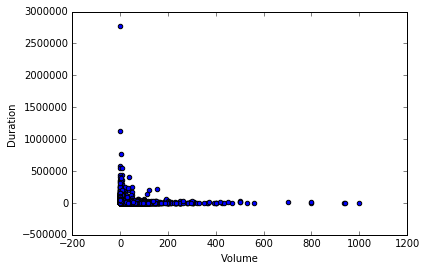

In [59]:
fig, ax = subplots()
nonz=style_df[style_df['ReturnTradedPrice']!=0]
zero=style_df[style_df['ReturnTradedPrice']==0]
ax.scatter(nonz['Volume'], nonz['Duration'], cmap='gray')
# ax.set_aspect(1)
# xlim(np.min(z['ReturnTradedPrice']), np.max(z['ReturnTradedPrice']))
# ylim(np.max(z['Duration']), np.max(z['Duration']))
xlabel('Volume')
ylabel('Duration')
# title('Volume') ;
ax.scatter(zero['Volume'], zero['Duration'], cmap='gray')


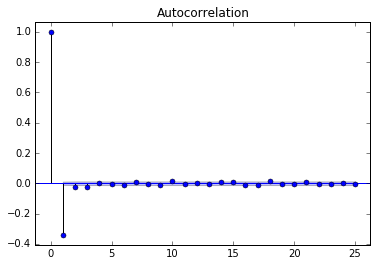

In [68]:
_=plot_acf(df['ReturnTradedPrice'], lags =25)

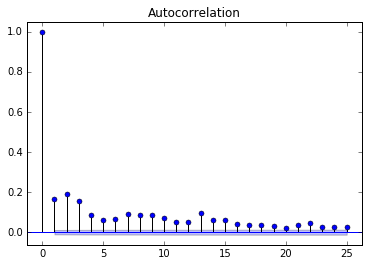

In [67]:
_=plot_acf(df['Duration'], lags =25)

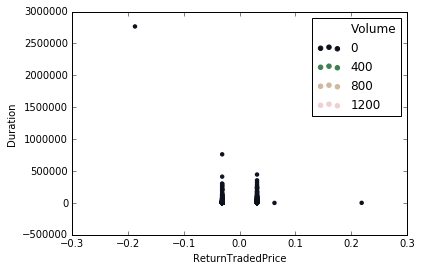

In [82]:
x_nz = nonz['ReturnTradedPrice']
dur_nz= nonz['Duration']
vol_nz = nonz['Volume']
sns.scatterplot(x=x_nz, y=dur_nz, hue=vol_nz,sizes=(1, 8),palette="ch:r=-.8,d=.07_r", linewidth=0)
# Plot a historgram and kernel density estimate


In [ ]:
sns.distplot(dur_nz, color="m")

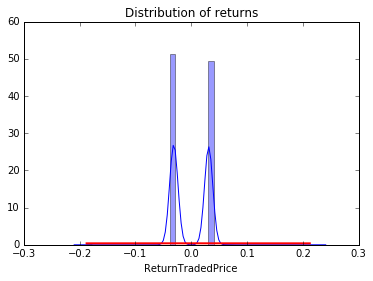

In [75]:
import scipy.stats as scs

# Plotting the distribution of the returns ----
ax = sns.distplot(x_nz, kde = True, norm_hist=True)                                    

xx = np.arange(min(x_nz), max(x_nz), 0.01)                                                   
yy = scs.norm.pdf(xx)                                                         
ax.plot(xx, yy, 'r', lw=2)
_=ax.set_title('Distribution of returns')

In [ ]:
import statsmodels.formula.api as smf
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot

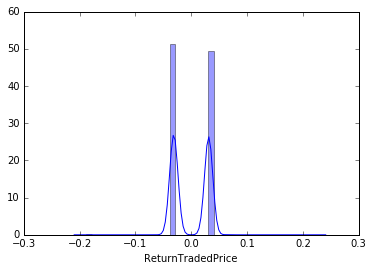

In [76]:
ticker_data =x_nz
ticker_data_len = len(ticker_data)
sns.distplot(x_nz)